# 11.3 Data Visualization with PCA and t-SNE
We will use PCA and t-SNE dimensionality reduction so that we can produce 2D visualizations of MNIST and DIGITS datasets.


In [1]:
# Mount GDrive, change directory and check contents of folder.

import os
from google.colab import drive
from google.colab import files

PROJECT_FOLDER = "/content/gdrive/My Drive/Colab Notebooks/CS345_SP22/11. Dimensionality Reduction"

drive.mount('/content/gdrive/')
os.chdir(PROJECT_FOLDER)
print("Current dir: ", os.getcwd())

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
Current dir:  /content/gdrive/My Drive/Colab Notebooks/CS345_SP22/11. Dimensionality Reduction


In [2]:
import os
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from data.digits import CDIGITSDataSet
from data.mnist import CMNISTDataSet

Helper class

In [3]:
# =========================================================================================================================
class CUnsupervisedEmbeddings(object):
  # --------------------------------------------------------------------------------------
  def __init__(self, p_sName, p_nSamples, p_nLabels):
    self.Name         = p_sName
    self.Samples      = p_nSamples
    self.Labels       = p_nLabels
    self.ClusterCount = len(np.unique(self.Labels))
    self.PCAModels  = []
    self.TSNEModels = []
    self.EmbeddingsLinear    = None
    self.EmbeddingsNonLinear = None
  # --------------------------------------------------------------------------------------
  def ClearModels(self, p_bIsClearingTSNEOnly=False):
    if not p_bIsClearingTSNEOnly:
      self.PCAModels  = []
    self.TNSEModels = []    
  # --------------------------------------------------------------------------------------
  def AddPCAModel(self, p_oPCAModel):
    self.PCAModels.append([p_oPCAModel, p_oPCAModel.n_components_, np.sum(p_oPCAModel.explained_variance_ratio_)])
  # --------------------------------------------------------------------------------------
  def AddTSNEModel(self, p_oTSNEModel, p_nComponents):
    self.TSNEModels.append([p_oTSNEModel, p_nComponents, p_oTSNEModel.kl_divergence_])
  # --------------------------------------------------------------------------------------
  def GetPCAPlotSerie(self):
    nX = [oRec[1] for oRec in self.PCAModels]
    nY = [oRec[2] for oRec in self.PCAModels] 
    return nX, nY
  # --------------------------------------------------------------------------------------
  def GetTSNEPlotSerie(self):
    nX = [oRec[1] for oRec in self.TSNEModels]
    nY = [oRec[2] for oRec in self.TSNEModels] 
    return nX, nY
  # --------------------------------------------------------------------------------------
# =========================================================================================================================

# Data Loading and Normalization
Create to different sets of models for the two datasets, DIGITS and MNIST

In [4]:
oDIGITS = CDIGITSDataSet() 
oMNIST  = CMNISTDataSet()


# Min-max scale the samples of DIGITS
oDIGITS.Samples = MinMaxScaler().fit_transform(oDIGITS.TSSamples)

# Min-max scale the samples of MNIST
oMNIST.Samples = MinMaxScaler().fit_transform(oMNIST.TSSamples)


print("Training samples shape for DIGITS:", oDIGITS.Samples.shape)
print("Training samples shape for MNIST:", oMNIST.Samples.shape)

Training samples shape for DIGITS: (1797, 64)
Training samples shape for MNIST: (60000, 784)


# Hyperparameters for Dimensionality Reduction

In [5]:
# _____// Hyperparameters \\_____
# ... Data Hyperparameters ...
#SAMPLE_COUNT = 100 # t-SNE fails with few samples (needs more to learn)
#SAMPLE_COUNT = 200
SAMPLE_COUNT = 1700  

# ... Dimensionality Reduction Hyperparameters ...
COMPONENTS      = 2
PERPLEXITY      = 100.0
LEARNING_RATE   = 200.0
INITIALIZATION  = 'random'
EPOCHS          = 1000
#GRADIENT_CALCULATION_ALGORITHM = "exact" #Slow but for higher number of components
GRADIENT_CALCULATION_ALGORITHM = "barnes_hut" #Fast

oDRModels = []
oDRModels.append(CUnsupervisedEmbeddings("DIGITS", oDIGITS.TSSamples[:SAMPLE_COUNT,:], oDIGITS.TSLabels[:SAMPLE_COUNT]))
oDRModels.append(CUnsupervisedEmbeddings("MNIST" , oMNIST.TSSamples[:SAMPLE_COUNT,:], oMNIST.TSLabels[:SAMPLE_COUNT]))

# Training for Dimensionality Reduction
Train a PCA and a t-SNE model with 2 components on DIGITS and MNIST, in order to produce a 2D visualization of the samples.

In [6]:
# Creating PCA Models
for oDRM in oDRModels:
    oDRM.ClearModels()

    print("-"*25, "PCA on %s with %d Components" % (oDRM.Name, COMPONENTS), "-"*25)
    oPCA = PCA(n_components=COMPONENTS)
    oPCA.fit(oDRM.Samples)
    oDRM.EmbeddingsLinear = oPCA.transform(oDRM.Samples)
    oDRM.AddPCAModel(oPCA)


    print("-"*25, "t-SNE on %s with %d Components" % (oDRM.Name, COMPONENTS), "-"*25)
    oTSNE = TSNE( n_components=COMPONENTS
                 ,perplexity=PERPLEXITY, n_iter=EPOCHS
                 ,method=GRADIENT_CALCULATION_ALGORITHM
                 ,learning_rate=LEARNING_RATE
                 ,init=INITIALIZATION
                 )
    oDRM.EmbeddingsNonLinear = oTSNE.fit_transform(oDRM.Samples)
    oDRM.AddTSNEModel(oTSNE, COMPONENTS)

------------------------- PCA on DIGITS with 2 Components -------------------------
------------------------- t-SNE on DIGITS with 2 Components -------------------------
------------------------- PCA on MNIST with 2 Components -------------------------
------------------------- t-SNE on MNIST with 2 Components -------------------------


# Visualization
Visualize the 2D embeddings for the samples in the manifold feature space that is learned from PCA and t-SNE.

PCA vs t-SNE on DIGITS and MNIST


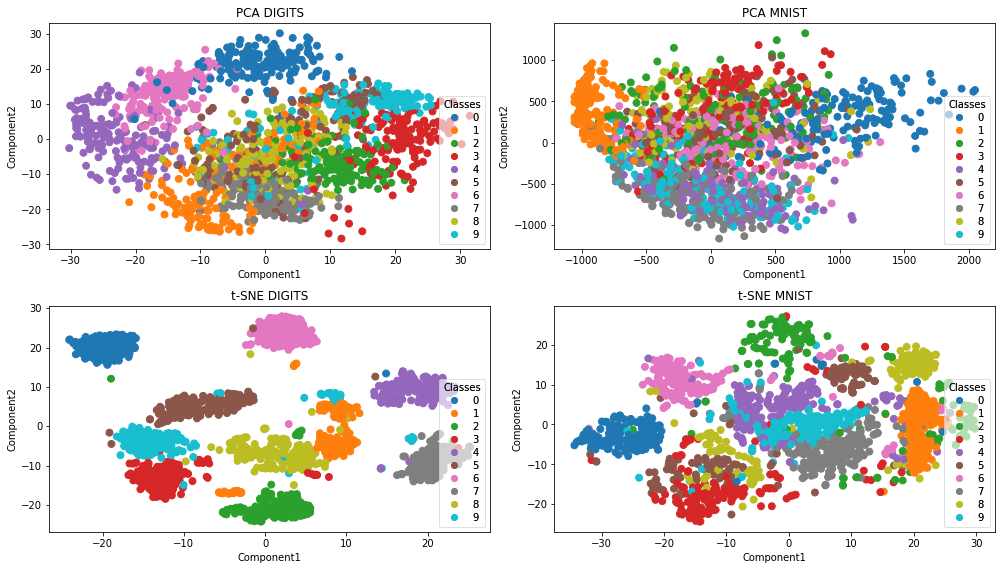

--------------------------------------------------------------------------------
PCA vs t-SNE on DIGITS and MNIST (No Ground Truth)


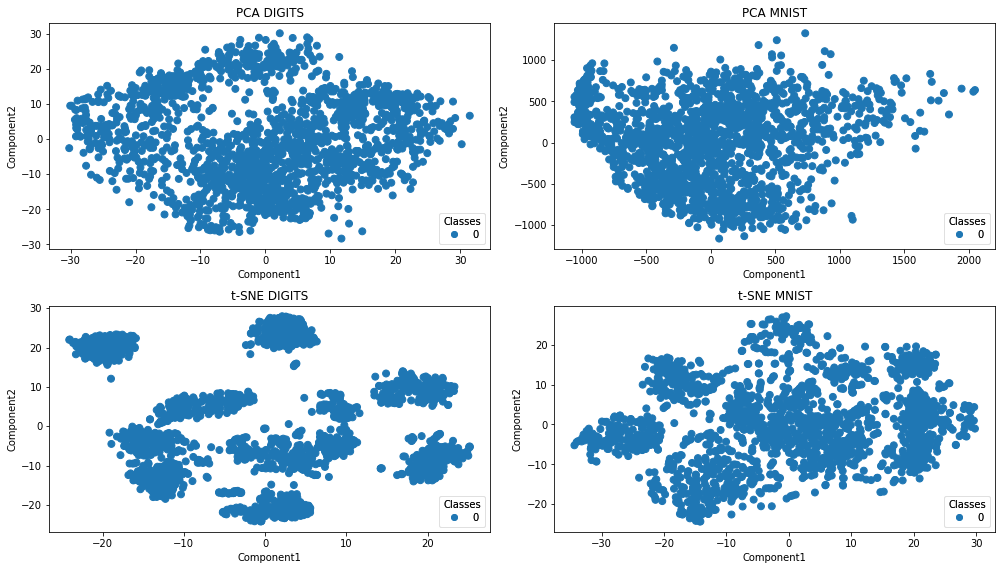

In [7]:
import matplotlib.pyplot as plt
from mllib.visualization import CMultiScatterPlot

print("PCA vs t-SNE on DIGITS and MNIST")
oPlot = CMultiScatterPlot("PCA vs t-SNE on DIGITS and MNIST")
for oDRM in oDRModels:
  oPlot.AddData("PCA %s" % oDRM.Name  , oDRM.EmbeddingsLinear   , oDRM.Labels)
  oPlot.AddData("t-SNE %s" % oDRM.Name, oDRM.EmbeddingsNonLinear, oDRM.Labels)

for nIndex in range(0, 4):
  oPlot.Show(nIndex, "Component1", "Component2")

print("-"*80)
print("PCA vs t-SNE on DIGITS and MNIST (No Ground Truth)")

oPlot = CMultiScatterPlot("PCA vs t-SNE on DIGITS and MNIST (No Ground Truth)")
for oDRM in oDRModels:
  oPlot.AddData("PCA %s" % oDRM.Name  , oDRM.EmbeddingsLinear   )
  oPlot.AddData("t-SNE %s" % oDRM.Name, oDRM.EmbeddingsNonLinear)

for nIndex in range(0, 4):
  oPlot.Show(nIndex, "Component1", "Component2")